# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오고 살펴보기 

In [86]:
d_path = '/content/drive/MyDrive/Colab Notebooks/Dacon1/'
train = pd.read_csv(d_path + 'train_df.csv')
submission = pd.read_csv(d_path + 'sample_submission.csv')

train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


### 스케일링 해보자

In [21]:
train.describe()

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,924.749249,467.575095,927.864940,458.902909,923.639796,459.914639,930.487292,463.990753,924.639941,464.621324,944.381139,501.593308,926.468799,504.626364,951.324044,549.872925,923.372414,552.408616,948.098403,581.880637,929.048645,585.008666,962.231334,607.496524,953.374920,606.482292,973.987291,673.247179,963.484991,673.081170,985.607430,768.641511,977.900015,768.073248,934.087074,486.899058,948.048605,592.538893,930.927976,594.058241,942.188765,531.404189,953.269124,572.859401,988.700361,789.336652,980.353135,788.394621
std,172.394760,139.045600,176.793123,142.868661,177.599445,142.907682,166.772969,144.182997,167.356988,145.071886,132.157119,111.803917,134.500805,114.294835,147.410554,109.641120,149.976567,113.486690,159.389656,138.425281,155.862210,135.522992,81.615345,59.193616,86.086447,64.121352,126.003833,99.041700,131.482418,93.090388,179.568604,129.855875,185.212268,130.077352,144.992244,126.811033,166.613799,141.822243,163.394363,142.409977,99.481793,92.387541,82.032200,65.902173,198.327819,134.676821,203.542785,136.286608
min,599.537515,236.000000,604.328953,228.000000,592.879610,228.000000,592.879610,237.000000,585.797372,239.000000,629.126324,281.000000,613.000000,301.915357,579.774055,231.000000,506.778296,187.291436,496.715724,160.901561,582.561593,192.953986,709.000000,279.060265,630.608155,185.530333,641.000000,160.467917,635.000000,196.203906,566.632895,275.430917,562.214888,258.233566,641.553624,281.836992,484.715724,177.582703,555.658256,177.582703,685.585234,299.490534,699.984140,309.261220,522.715133,257.389455,516.491925,237.187979
25%,780.336720,345.420994,780.979440,334.054071,773.000000,334.000000,799.415237,340.673417,792.389148,341.397937,831.053528,410.000000,836.000000,413.000000,844.748293,473.000000,824.258636,473.000000,840.450494,518.999084,824.321537,519.427300,898.959181,579.000000,899.000000,577.502180,872.000000,595.000000,873.000000,609.829559,855.000000,691.024647,848.528614,682.838491,823.694542,374.607215,834.843287,526.850592,819.047567,527.977957,873.585116,458.909191,889.943091,525.105188,837.236253,712.665663,847.176763,710.634727
50%,932.000000,462.386181,943.000000,449.000000,923.000000,451.101314,952.673164,438.816448,910.000000,441.000000,956.000000,472.000000,900.000000,478.241036,963.000000,531.201994,897.058830,534.000000,983.031340,585.153465,903.766675,588.356930,977.000000,604.420070,939.000000,600.550657,987.000000,716.000000,933.000000,712.000000,989.000000,840.000000,939.000000,828.457260,938.000000,464.000000,980.327601,605.000000,905.566531,599.000000,945.859735,513.827581,967.000000,560.563925,987.000000,856.000000,939.000000,845.000000
75%,1067.537031,578.792495,1064.419621,567.498944,1071.528493,572.000000,1040.000000,575.419554,1063.282200,570.736769,1038.000000,586.449343,1035.00000

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             4195 non-null   object 
 1   nose_x            4195 non-null   float64
 2   nose_y            4195 non-null   float64
 3   left_eye_x        4195 non-null   float64
 4   left_eye_y        4195 non-null   float64
 5   right_eye_x       4195 non-null   float64
 6   right_eye_y       4195 non-null   float64
 7   left_ear_x        4195 non-null   float64
 8   left_ear_y        4195 non-null   float64
 9   right_ear_x       4195 non-null   float64
 10  right_ear_y       4195 non-null   float64
 11  left_shoulder_x   4195 non-null   float64
 12  left_shoulder_y   4195 non-null   float64
 13  right_shoulder_x  4195 non-null   float64
 14  right_shoulder_y  4195 non-null   float64
 15  left_elbow_x      4195 non-null   float64
 16  left_elbow_y      4195 non-null   float64


In [88]:
train1 = train.drop(['image'], axis = 1)

In [89]:
col = train1.columns.tolist()
col

['nose_x',
 'nose_y',
 'left_eye_x',
 'left_eye_y',
 'right_eye_x',
 'right_eye_y',
 'left_ear_x',
 'left_ear_y',
 'right_ear_x',
 'right_ear_y',
 'left_shoulder_x',
 'left_shoulder_y',
 'right_shoulder_x',
 'right_shoulder_y',
 'left_elbow_x',
 'left_elbow_y',
 'right_elbow_x',
 'right_elbow_y',
 'left_wrist_x',
 'left_wrist_y',
 'right_wrist_x',
 'right_wrist_y',
 'left_hip_x',
 'left_hip_y',
 'right_hip_x',
 'right_hip_y',
 'left_knee_x',
 'left_knee_y',
 'right_knee_x',
 'right_knee_y',
 'left_ankle_x',
 'left_ankle_y',
 'right_ankle_x',
 'right_ankle_y',
 'neck_x',
 'neck_y',
 'left_palm_x',
 'left_palm_y',
 'right_palm_x',
 'right_palm_y',
 'spine2(back)_x',
 'spine2(back)_y',
 'spine1(waist)_x',
 'spine1(waist)_y',
 'left_instep_x',
 'left_instep_y',
 'right_instep_x',
 'right_instep_y']

In [90]:
train2 = train[['image']]
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4195 entries, 0 to 4194
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4195 non-null   object
dtypes: object(1)
memory usage: 32.9+ KB


In [91]:
scaler = RobustScaler()
train_s = scaler.fit_transform(train1)   # 0,49 object

In [92]:
train_s

array([[ 0.39829215, -0.50403883,  0.3480639 , ..., -0.16956974,
         0.50031934, -0.03422241],
       [ 0.47998095, -0.52137766,  0.40787637, ..., -0.9088118 ,
         0.51309748, -0.01940814],
       [ 0.53090438, -0.53728142,  0.47882413, ..., -0.27357543,
         0.51186961, -0.01802146],
       ...,
       [-1.02628352,  1.36673106,  0.61436532, ..., -1.41017024,
        -1.29948007, -0.23042428],
       [-1.02628352,  1.36673106,  0.61436532, ..., -1.41017024,
        -1.29948007, -0.23042428],
       [-1.02628352,  1.36673106,  0.61436532, ..., -1.41017024,
        -1.29948007, -0.23042428]])

In [93]:
train_r = pd.DataFrame(train_s, columns = col)    # 스케일링 한 데이터로 데이터프레임 재구성, image 미포함

In [94]:
# train_r['image'] = train2
train2[col] = train_r

In [95]:
train = train2

In [96]:
print(train)

                              image    nose_x  ...  right_instep_x  right_instep_y
0      001-1-1-01-Z17_A-0000001.jpg  0.398292  ...        0.500319       -0.034222
1      001-1-1-01-Z17_A-0000003.jpg  0.479981  ...        0.513097       -0.019408
2      001-1-1-01-Z17_A-0000005.jpg  0.530904  ...        0.511870       -0.018021
3      001-1-1-01-Z17_A-0000007.jpg  0.384122  ...        0.888285       -1.361737
4      001-1-1-01-Z17_A-0000009.jpg  0.438880  ...        0.485906       -0.029024
...                             ...       ...  ...             ...             ...
4190  642-2-4-31-Z148_E-0000023.jpg -1.026284  ...       -1.299480       -0.230424
4191  642-2-4-31-Z148_E-0000025.jpg -1.026284  ...       -1.299480       -0.230424
4192  642-2-4-31-Z148_E-0000027.jpg -1.026284  ...       -1.299480       -0.230424
4193  642-2-4-31-Z148_E-0000029.jpg -1.026284  ...       -1.299480       -0.230424
4194  642-2-4-31-Z148_E-0000031.jpg -1.026284  ...       -1.299480       -0.230424

[41

----------------------------

In [97]:
train.shape

(4195, 49)

In [98]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


많은 파일들을 다뤄야 하는 파이썬 프로그램을 작성할 때, 특정한 패턴이나 확장자를 가진 파일들의 경로나 이름이 필요할 때가 있다. glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다. 단, 조건에 정규식을 사용할 수 없으며 엑셀 등에서도 사용할 수 있는 '*'와 '?'같은 와일드카드만을 지원한다.

In [99]:
#glob를 활용해 이미지의 경로들을 불러옵니다.
import glob
train_paths = glob.glob(d_path + '/train_imgs/*.jpg')   # 현재 디렉터리의 .jpg 파일
test_paths = glob.glob(d_path + './test_imgs/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


# 시각화

주어진 이미지와 keypoint지점을 비교해보며 데이터에 대한 이해도를 높여봐요!

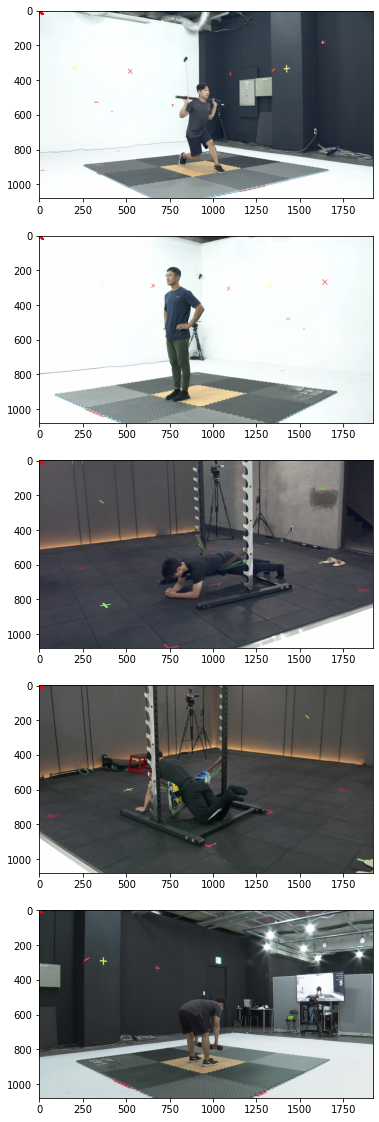

In [100]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1


# 모델링

In [101]:
train['path'] = train_paths

대용량 이미지를 불러올 때 Generator 를 활용해서 불러옵니다.

In [102]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float64, tf.float64), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [103]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [104]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

In [105]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [ ]:
model.fit(train_dataset,epochs = 5, verbose=1)

Epoch 1/5
132/132 [==============================] - 1766s 13s/step - loss: 87.7590 - mae: 2.7026
Epoch 2/5
132/132 [==============================] - 1799s 14s/step - loss: 0.3903 - mae: 0.4665
Epoch 3/5
132/132 [==============================] - 1808s 14s/step - loss: 0.3900 - mae: 0.4685
Epoch 4/5
 10/132 [=>............................] - ETA: 27:31 - loss: 0.3319 - mae: 0.4410

# test 데이터

In [15]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 1600/1600 [08:30<00:00,  3.14it/s]


In [16]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [17]:
pred=model.predict(X_test)

# 제출하기

In [18]:
submission.iloc[:,1:]=pred

In [19]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1146.197632,648.734558,1194.871460,646.238464,1221.581665,658.609619,1136.838867,758.701172,1129.028564,664.474121,1126.549561,780.240967,1199.786011,788.434448,1198.976318,638.634583,1194.700439,661.720398,1138.975220,614.523865,1189.431152,586.444519,1329.990845,780.451355,1334.614868,774.967468,1320.860718,746.081543,1417.759521,700.563538,1399.541504,981.586792,1491.149170,932.931152,1221.576538,777.743042,1139.912354,627.694458,1281.692383,635.554504,1245.815186,780.906006,1320.289551,789.386719,1421.894165,961.618835,1439.072998,1049.964355
1,649-2-4-32-Z148_A-0000003.jpg,1405.203369,718.565125,1380.840332,748.463867,1396.936890,769.710693,1319.298584,840.583191,1302.842773,778.691284,1291.987671,893.443604,1391.532227,836.602905,1385.374756,680.469543,1372.430298,780.874695,1348.721313,708.382996,1418.069946,687.504333,1388.975708,834.431458,1480.096924,858.735596,1489.297974,798.583435,1499.939087,791.602722,1467.099121,1100.536011,1546.184204,1172.406616,1469.147827,816.907776,1328.536621,767.214172,1461.960815,658.588379,1433.378540,763.083008,1481.815308,877.827698,1534.859741,1091.606934,1516.592896,1226.682129
2,649-2-4-32-Z148_A-0000005.jpg,1420.036133,728.381165,1390.828735,757.420105,1412.045532,781.823364,1332.005493,848.324402,1311.808960,790.582764,1307.029663,904.919189,1404.288208,847.725647,1405.915771,689.511414,1377.385132,786.674927,1364.404297,713.580261,1416.160522,698.452454,1407.461792,841.493591,1494.143311,869.853333,1515.511108,807.134888,1521.873169,797.723694,1489.613525,1112.496948,1569.466919,1189.372803,1485.463257,829.003540,1342.211914,783.720947,1460.643188,668.607483,1451.234985,772.912231,1505.935669,888.062073,1568.716064,1102.925903,1538.766846,1236.323730
3,649-2-4-32-Z148_A-0000007.jpg,1130.530762,638.759521,1185.087891,642.768250,1208.422241,653.904968,1119.582275,741.105530,1114.492554,661.008240,1114.995117,776.489624,1185.947632,779.283081,1186.045898,635.323425,1186.392456,646.812012,1126.850952,603.127808,1173.929810,581.649597,1317.506714,778.059875,1321.884521,768.817932,1308.437622,741.411194,1399.570923,699.547424,1380.597900,980.414062,1478.189819,930.644775,1219.567993,763.660767,1128.792725,619.217041,1273.326172,621.915466,1235.442993,763.594971,1307.875977,789.404602,1414.741333,963.663635,1425.498779,1046.130371
4,649-2-4-32-Z148_A-0000009.jpg,1392.939209,709.002991,1366.151123,746.074951,1383.119507,769.121216,1299.219482,834.864563,1284.213501,771.278625,1271.505249,886.279114,1374.985962,827.031189,1365.083252,669.389465,1355.932007,772.697632,1329.470581,699.440002,1404.632080,680.199951,1363.742798,822.458740,1459.854004,851.408386,1467.215088,786.519409,1478.813843,782.938904,1439.135986,1088.535522,1519.500977,1156.204224,1454.306763,806.283936,1312.935547,754.789429,1448.537598,643.531433,1417.294556,749.608521,1465.678955,866.487366,1511.073120,1072.903931,1493.504150,1208.622192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,998.607788,535.304749,988.744263,531.922974,1041.678711,518.928162,969.981812,557.137878,972.164734,554.676331,940.044617,570.314209,1017.853699,587.726929,1046.113281,487.441345,979.007874,540.605835,977.344299

In [20]:
# submission.to_csv('baseline_submission.csv', index=False)
submission.to_csv(d_path + 'test_submission1.csv', index=False)